#### Package requirements:
```python
numpy
skimage
scipy
matplotlib
PIL
```

In [84]:
import numpy as np
from skimage.feature import canny, peak_local_max, hog
from skimage.color import rgb2gray
from skimage.morphology import dilation, erosion, watershed, reconstruction
from skimage.transform import resize,rotate
from skimage.filters import sobel, gaussian

from sklearn.svm import SVC

from scipy import ndimage as ndi
from matplotlib import pyplot as plt

%matplotlib inline

#### Load the example data and visualization

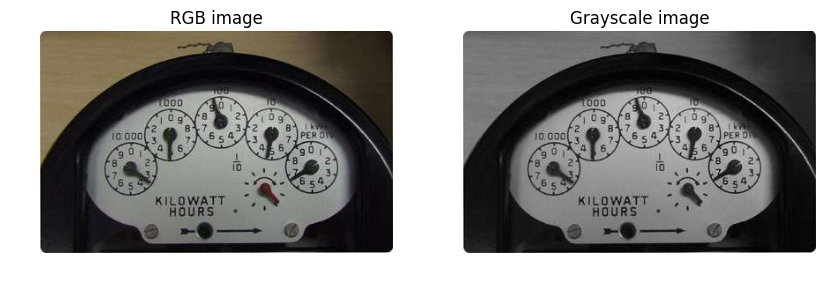

In [3]:
# Load the RGB image and convert it to Grayscale
data = ndi.imread("data/sample.jpg")
data_gray = rgb2gray(data)

# Visualize data
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].imshow(data)
axarr[0].axis('off')
axarr[0].set_title("RGB image")
axarr[1].imshow(data_gray, cmap='gray')
axarr[1].axis('off')
axarr[1].set_title("Grayscale image")
plt.show()

#### Image processing and segmentation
The pipeline is as follows:
* Canny Edge Detection
* Fill holes using the edge image
* First round of segmentation, segmenting 5 meters
* Second round of segmentation, because these 5 meters are overlapped we should segment them again

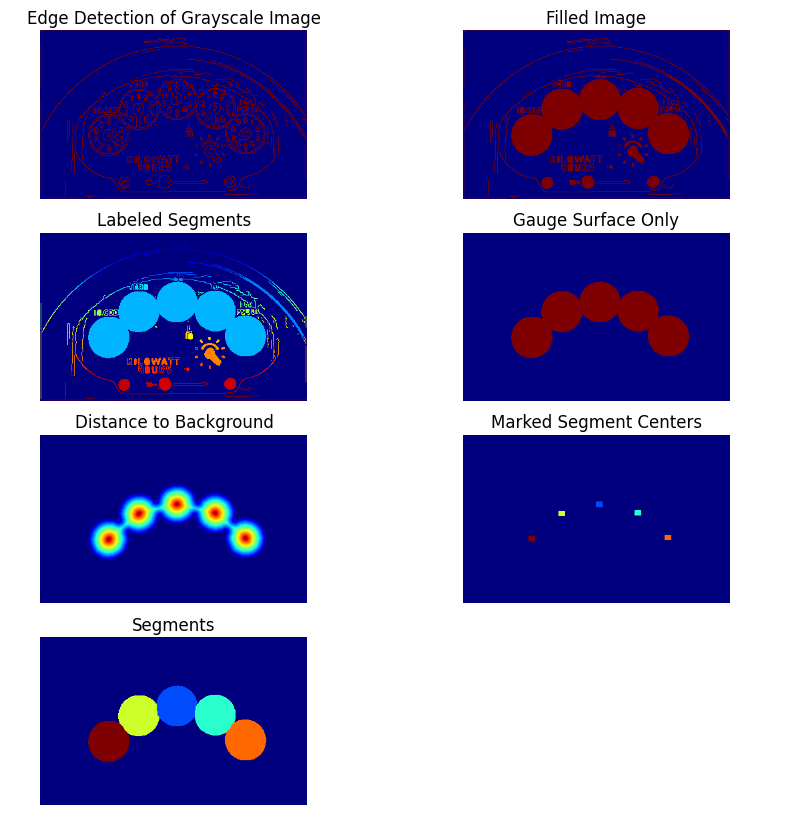

In [5]:
# Apply canny edge detector, may need to adjust sigma for performance
data_edge = canny(data_gray, sigma=0.6)

# Close the holes from canny detector
segmentation = ndi.binary_fill_holes(data_edge)

# Label these segments
segmentation_labeled, n_classes = ndi.label(segmentation)

# Count number of pixels for each segment
sizes = np.bincount(segmentation_labeled.ravel())

# Filter out small objects whose pixel numbers are smaller than 
# 10% of the entire image
sum_pixels = data_edge.shape[0] * data_edge.shape[1]
mask_sizes = sizes > (0.1 * sum_pixels)
mask_sizes[0] = 0
gauge_face = mask_sizes[segmentation_labeled]

# Calculate the distance of object pixel to closest background pixel
distance = ndi.distance_transform_edt(gauge_face)

# Find the local maxima on the image, num_peaks could be 
# adjustable values depending on how circles on the image
peak_local_maxima = peak_local_max(distance, indices=False, num_peaks=5)
markers = ndi.label(peak_local_maxima)[0]

# Segement the overlapped objects using watershed algorithm
overlap_segmentation = watershed(-distance, markers, mask = gauge_face)

fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
axarr[0, 0].imshow(data_edge)
axarr[0, 0].axis('off')
axarr[0, 0].set_title('Edge Detection of Grayscale Image')
axarr[0, 1].imshow(segmentation)
axarr[0, 1].axis('off')
axarr[0, 1].set_title('Filled Image')
axarr[1, 0].imshow(segmentation_labeled)
axarr[1, 0].axis('off')
axarr[1, 0].set_title('Labeled Segments')
axarr[1, 1].imshow(gauge_face)
axarr[1, 1].axis('off')
axarr[1, 1].set_title('Gauge Surface Only')
axarr[2, 0].imshow(distance)
axarr[2, 0].axis('off')
axarr[2, 0].set_title('Distance to Background')
axarr[2, 1].imshow(dilation(markers, np.ones((8, 10))))
axarr[2, 1].axis('off')
axarr[2, 1].set_title('Marked Segment Centers')
axarr[3, 0].imshow(overlap_segmentation)
axarr[3, 0].axis('off')
axarr[3, 0].set_title('Segments')
axarr[3, 1].axis('off')
plt.show()

#### Training Data Auto Generation

In [6]:
def load_boundary_idx(gray_img):
    obj_idx = np.where(gray_img > 0.)
    return (np.min(obj_idx[0]), np.max(obj_idx[0]), 
            np.min(obj_idx[1]), np.max(obj_idx[1]))

In [34]:
unique_objects = np.delete(np.unique(overlap_segmentation), 0)
    
def separate_arrow_scale(data_gray, segmentation, object_id):
    temp_data_gray = np.copy(data_gray)
    temp_data_gray[segmentation != object_id] = 0

    # Get the indices bound of the object from the original image
    y_lb, y_ub, x_lb, x_ub = load_boundary_idx(temp_data_gray)

    # Zoom into the object and standardize the shape 
    # (standardization is important for machine learning)
    zoom_temp_data_gray = resize(temp_data_gray[y_lb:y_ub+1, x_lb:x_ub+1], 
                                 (60, 60))
    markers = np.zeros_like(zoom_temp_data_gray)
    markers[np.logical_and(zoom_temp_data_gray < 0.24, 
                           zoom_temp_data_gray > 0)] = 1
    markers[zoom_temp_data_gray > 0.4] = 2
    
    unlabeled_arrow = np.zeros_like(markers)
    unlabeled_arrow[markers==1] = 1
    unlabeled_arrow = dilation(dilation(erosion(unlabeled_arrow)))
    
    labeled_arrow = ndi.label(unlabeled_arrow)[0]
    label_count = np.bincount(labeled_arrow.ravel())
    label_count_sorted = np.sort(label_count)
    
    mask_arrow = label_count==label_count_sorted[-2]
    mask_arrow[0] = 0
    
    # Gaussian smooth, may need to adjust sigma and the threshold
    mask_arrow_cleaned = gaussian(mask_arrow[labeled_arrow], sigma=0.4) > 0.2
    mask_arrow_rotated = rotate(mask_arrow_cleaned, 90)
    
    arrow_cleaned = np.copy(zoom_temp_data_gray)
    arrow_cleaned[~mask_arrow_cleaned] = 0
    scale = np.copy(zoom_temp_data_gray)
    
    # Estimate scale mean and std
    scale_white = scale[scale >= 0.6]
    scale_white_mean = np.mean(scale_white)
    scale_white_std = np.std(scale_white)
    
    scale_white_random = np.random.normal(scale_white_mean, scale_white_std/2., len(np.where(mask_arrow_cleaned)[0]))
    scale[mask_arrow_cleaned] = scale_white_random
    
#     seed = np.copy(scale)
#     seed[dilation(mask_arrow_cleaned, selem=np.ones((7,7)))] = scale.max()
    
#     mask = np.copy(scale)
    
#     scale = reconstruction(seed, mask, method='erosion')
    
    arrow_rotated = rotate(arrow_cleaned, 90)
    
    fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(5, 2.5))
    axarr[0].imshow(arrow_cleaned, cmap='gray')
    axarr[0].axis('off')
    axarr[0].set_title('Arrow')
    axarr[1].imshow(scale, cmap='gray')
    axarr[1].axis('off')
    axarr[1].set_title('Scale')
    plt.show()
    
    return arrow_cleaned, scale

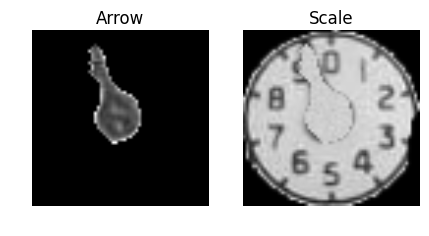

1


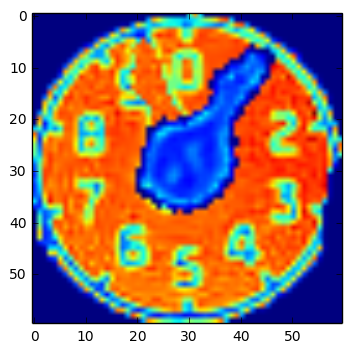

2


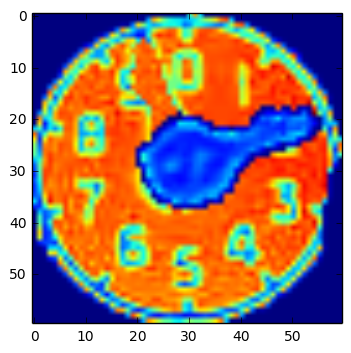

3


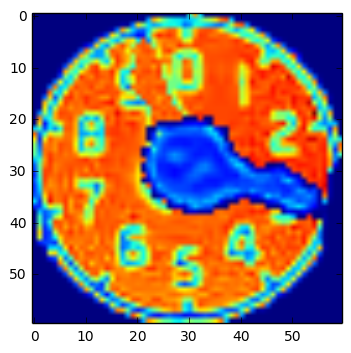

4


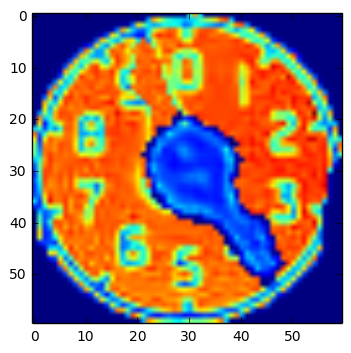

5


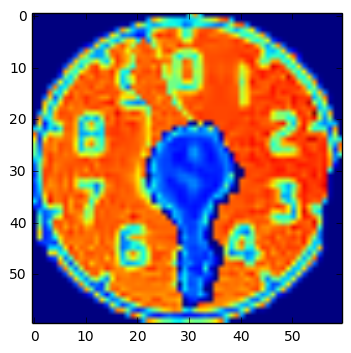

6


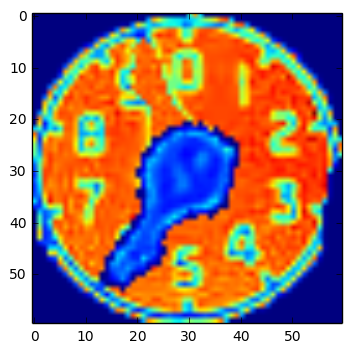

7


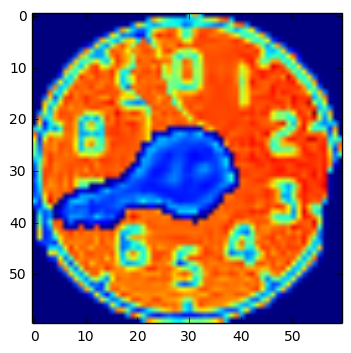

8


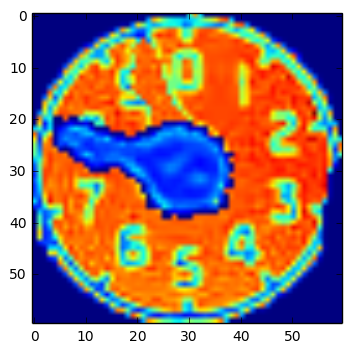

9


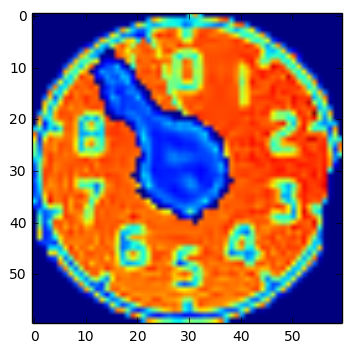

(3600, 60, 60)
(3600,)


In [38]:
arrow, scale = separate_arrow_scale(data_gray, overlap_segmentation, 1)
arrow = rotate(arrow, -18)

number = 0
train_x = np.zeros((len(np.arange(0., 360., 0.1)), arrow.shape[0], arrow.shape[1]))
train_y = np.zeros(len(np.arange(0., 360., 0.1)))

for i, deg in enumerate(np.arange(0., 360., 0.1)):
    temp_scale = np.copy(scale)
    arrow_rotated = rotate(arrow, -deg)
    temp_scale[arrow_rotated > 0.] = arrow_rotated[arrow_rotated > 0.]
    if deg != 0. and (deg % 36.) == 0:
        number += 1
        print number
        plt.imshow(temp_scale)
        plt.show()
    train_x[i] = temp_scale
    train_y[i] = number

1800


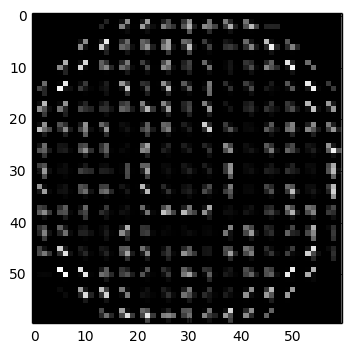

In [91]:
fd, hog_img = hog(train_x[0], orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
print len(fd)
plt.imshow(hog_img, cmap='gray', interpolation='none')
plt.show()

train_x_hog = np.zeros((len(train_x), len(fd)))

for i, temp_img in enumerate(train_x):
    train_x_hog[i] = hog(temp_img, orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=False)

In [92]:
# Shuffle train test indices
idx_array = np.arange(0, len(train_x_hog))
random_train_idx = np.random.choice(idx_array, int(0.8 * len(idx_array)), replace=False)
random_test_idx = np.delete(idx_array, random_train_idx)

# train test split
random_train_x_hog = train_x_hog[random_train_idx]
random_train_y = train_y[random_train_idx]
random_test_x_hog = train_x_hog[random_test_idx]
random_test_y = train_y[random_test_idx]

In [93]:
svc = SVC()

svc.fit(random_train_x_hog, random_train_y)
pred_y = svc.predict(random_test_x_hog)

print pred_y
print random_test_y

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3

In [94]:
true_counter = 0.
for temp_pred, temp_true in zip(pred_y, random_test_y):
    if temp_pred == temp_true:
        true_counter += 1.
        
print "Accuracy is:", true_counter / float(len(pred_y))

Accuracy is: 0.984722222222
